In [16]:
import re
import random
import pandas as pd
import hashlib

In [17]:
with open("certcards2.txt", mode="r", encoding="utf8") as f:
    all_cards = f.read()

card_split_pattern = r"\n\n\n\d+\n"
all_cards = re.split(card_split_pattern, all_cards)
# Use re.DOTALL to allow . to match newline characters
card_pattern = re.compile(r"(.+?)\n([\s\S]+)", re.DOTALL)
cards = [
    (match.group(1), match.group(2))
    for cstring in all_cards
    if (match := re.search(card_pattern, cstring))
]

# removing the cards that have no content and trimming
cards = [
    (subject, stripped_content)
    for subject, content in cards
    if len(stripped_content := content.strip()) > 5
]


def hash_string_md5(s):
    """
    Hashes a string using MD5 and returns a truncated hash for efficiency.

    Parameters:
    - s (str): The input string to hash.

    Returns:
    - str: The truncated hexadecimal hash string.
    """
    if pd.isnull(s):
        return None  # Handle NaN values gracefully
    return hashlib.md5(s.encode("utf-8")).hexdigest()


def remake_card_document(
    existing_cards: pd.DataFrame, filename: str = "certcards2.txt"
):
    with open(filename, mode="w", encoding="utf8") as f:
        i = 1
        for _, row in existing_cards.iterrows():
            f.write("\n" * 6)
            f.write(str(i) + "\n")
            f.write(row["head"] + "\n")
            f.write(row["body"])
            i += 1
    print(f"Cards found: {existing_cards.shape[0]}")
    print(f"Total card age: {abs(existing_cards['age'].sum()):.2f}")


existing_cards = pd.DataFrame(cards, columns=["head", "body"])


# existing_cards['age'] = [random.random() for _ in existing_cards.index]
existing_cards["hash"] = existing_cards["body"].apply(hash_string_md5)

card_ages = pd.read_json("card_ages.json")
card_ages = card_ages.drop_duplicates(subset=["hash"], keep="first")

cards_to_age = pd.merge(
    left=existing_cards,
    right=card_ages[["hash", "age"]],
    left_on="hash",
    right_on="hash",
    how="left",
)


cards_to_age["head"] = cards_to_age["head"].str.strip()

# remove headers I don't want anymore
undesired_headers = ["CCH Axcess"]
cards_to_age = cards_to_age.loc[~cards_to_age["head"].isin(undesired_headers), :].copy()

cards_to_age["age"] = cards_to_age["age"].fillna(0)

age_factor = 1.01
cards_to_age["age"] = cards_to_age["age"] * age_factor

cards_to_age["age"] = cards_to_age["age"] + [
    random.expovariate(0.5) for _ in cards_to_age.index
]
# cards_to_age['age'] = cards_to_age['age'] * [random.expovariate(1) for _ in cards_to_age.index]
mean = cards_to_age["age"].mean()
threshold = .005+(mean/1000)
shuffle_role = random.random()
print(f"{shuffle_role=}; {threshold=:.6f}")
if shuffle_role < threshold:
    cards_to_age["age"] = cards_to_age["age"] * [
        random.expovariate(1.3) for _ in cards_to_age.index
    ]

# Adding priority age growth to cards for upcoming certifications
priority_headers = [
    "Django", 
    "Python + Oauth2.0"
    ]
priority_cards_mask = cards_to_age["head"].isin(priority_headers)
cards_to_age.loc[priority_cards_mask, "age"] = (
    cards_to_age.loc[priority_cards_mask, "age"] * 1.0718
)

cards_to_age = cards_to_age.drop_duplicates(subset=["hash"], keep="first")

cards_to_age["subject_mean_age"] = cards_to_age.groupby("head")["age"].transform("mean")
cards_to_age["subject_highest_age"] = cards_to_age.groupby("head")["age"].transform(
    "max"
)
cards_to_age["subject_age_sum"] = cards_to_age.groupby("head")["age"].transform("sum")
cards_to_age["head_random_roll"] = cards_to_age.groupby("head")["head"].transform(
    lambda x: random.random()
)
cards_to_age["head_count"] = cards_to_age.groupby("head")["head"].transform("count")


cards_to_age.sort_values("hash")[["age", "head", "hash"]].to_json(
    "card_ages.json", indent=2
)

existing_cards = cards_to_age

shuffle_role=0.4702985744700252; threshold=0.056928


In [18]:
ave_order = ('age', 'mean')
sum_order = ('age', 'sum')

stats = existing_cards.groupby('head').agg({'age': ['sum', 'mean', 'max'], 'head': 'count'}).sort_values(sum_order)
stats.columns = stats.columns.to_flat_index()
stats.columns = ['_'.join(col).strip() for col in stats.columns]
stats.index.name = None
stats

,age_sum,age_mean,age_max,head_count
Power BI,35.113736,11.704579,16.351376,3
Network Terms,335.332551,22.355503,40.648937,15
Ubuntu,541.386417,20.822555,77.856086,26
GUI Docker Container,574.961001,27.379095,56.649283,21
Django,796.685343,56.906096,219.733106,14
WinHex,820.075700,41.003785,140.972504,20
SSH + SCP,824.604410,28.434635,103.728813,29
"Everything is Tuberculosis, Green",887.374653,38.581507,207.600881,23
CCH Tax Forms Project,1010.913831,59.465519,138.335961,17
Python + Oauth2.0,1070.723879,89.226990,198.452435,12


# Histogram

sum of ages: ~40006.16


<Axes: >

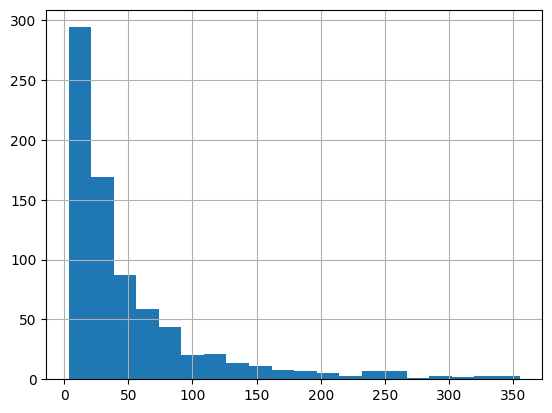

In [19]:
print(f"sum of ages: ~{existing_cards['age'].sum(0):.2f}")
existing_cards['age'].hist(bins=20)

sum of ages: ~40006.16


<Axes: >

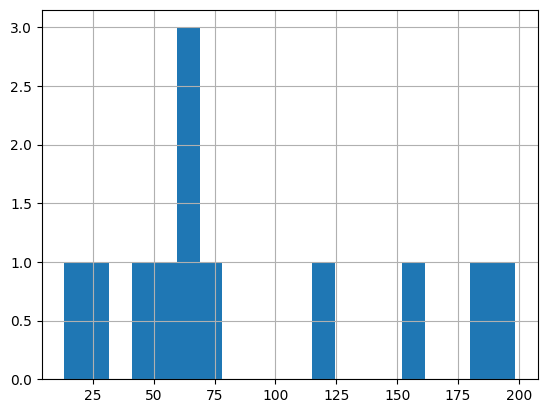

In [20]:
print(f"sum of ages: ~{existing_cards['age'].sum(0):.2f}")
existing_cards[existing_cards['head']=='Python + Oauth2.0']['age'].hist(bins=20)

# Completely Random Shuffle

In [21]:
# existing_cards = existing_cards.sample(frac=1)
# remake_card_document(filename='certcards2.txt', existing_cards = existing_cards)

# Age Sort

In [22]:
# existing_cards = existing_cards.sort_values('age', ascending=False)
# remake_card_document(filename='certcards2.txt', existing_cards=existing_cards)
# existing_cards.head(10)

# N-fold shuffle


## Age Sum

In [23]:
# n = 3
# m=existing_cards.shape[0]//100
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] // m

# existing_cards['subject_age_sum'] = existing_cards['subject_age_sum'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_age_sum', 'age'], inplace=True)

# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)


## Age Mean

In [24]:
# n=3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n

# existing_cards['subject_mean_age'] = existing_cards['subject_mean_age'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_mean_age', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)

# existing_cards.head(10)

## Age Max

In [25]:
n = random.choice([2, 3, 3, 4, 4, 5])

existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
existing_cards['n_fold'] = existing_cards['count'] // n

if existing_cards['age'].sum() > 0:
    existing_cards['subject_highest_age'] = existing_cards['subject_highest_age'] *-1
    existing_cards['neg_age'] = existing_cards['age'] *-1
existing_cards.sort_values(['n_fold', 'subject_highest_age', 'neg_age'], inplace=True)
# existing_cards.sort_values(['age'], inplace=True)

remake_card_document(existing_cards=existing_cards)
existing_cards.head(10)


Cards found: 768
Total card age: 40006.16


,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,head_count,count,n_fold,neg_age
1,Azure Files Documentation,Metadata caching is an enhancement for SSD Azu...,75e06c115adf39f142721e1ad795a557,354.893212,69.450684,-354.893212,2986.379407,0.991870,43,0,0,-354.893212
2,Azure Files Documentation,Ensure port 445 is open: The SMB protocol requ...,77e08c08f78b76a183210eb8b58b2b9e,259.683541,69.450684,-354.893212,2986.379407,0.991870,43,1,0,-259.683541
3,Azure Files Documentation,You can perform both item-level and share-leve...,57fb7bedb90f442a065e4b295b1fca97,233.171104,69.450684,-354.893212,2986.379407,0.991870,43,2,0,-233.171104
4,Active Directory and Azure Files,SRV Records\nDNS records used to locate servic...,f6d4521332358bf050d103389debc83d,345.427248,92.886031,-345.427248,3065.239033,0.827633,33,0,0,-345.427248
5,Active Directory and Azure Files,Kerberos Double-Hop\nA delegation problem wher...,e7196e7b196b58cc0b4b2b4a6a5e6949,330.420807,92.886031,-345.427248,3065.239033,0.827633,33,1,0,-330.420807
6,Active Directory and Azure Files,Kerberos Service Ticket\nA ticket issued by th...,abe21932a53e60679d96171f871e4106,271.431449,92.886031,-345.427248,3065.239033,0.827633,33,2,0,-271.431449
7,Python,Rotating File Handler\nlogging.handlers.Rotati...,e7c292c14924cb5ad6c123e2ed3b229a,338.470510,59.477988,-338.470510,3211.811342,0.262457,54,0,0,-338.470510
8,Python,NumPy-Style Docstrings\nStandard docstring for...,2c92f2301d5e8e4e17bda3e6462190df,292.892496,59.477988,-338.470510,3211.811342,0.262457,54,1,0,-292.892496
9,Python,import os\nfrom contextlib import contextmanag...,2c0d0fc1c34e81ab4b4e4dccc0c18248,177.302329,59.477988,-338.470510,3211.811342,0.262457,54,2,0,-177.302329
10,Windows PATH Variable,System PATH vs User PATH\nSystem PATH: Applies...,fab7edcaf5619e41df5ee4f39429b039,336.750765,67.707282,-336.750765,2031.218457,0.642092,30,0,0,-336.750765


## Card Count

In [26]:
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()

# choices = ['floor', 'mod']
# option = random.choice(choices)
# if option == 'floor':
#     n=5
#     existing_cards['n_fold'] = existing_cards['count'] // n
#     print("floor dividing for n-fold")
# elif option == 'mod':
#     n=3
#     existing_cards['n_fold'] = existing_cards['count'] % n
#     print("modulo for n-fold")
# else: raise NotImplementedError


# if existing_cards['age'].sum() > 0:
#     # existing_cards['neg_subject_highest_age'] = existing_cards['subject_highest_age'] *-1
#     existing_cards['neg_age'] = existing_cards['age'] *-1
#     existing_cards['subject_highest_age'] *= -1
# existing_cards.sort_values(['n_fold', 'head_count', 'subject_highest_age', 'neg_age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)

# existing_cards.head(10)


## Random

In [27]:
# n = 3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n
# existing_cards['age'] *= -1
# existing_cards.sort_values(['n_fold', 'head_random_roll', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)

In [28]:
existing_cards.head(10)['age'].sum()

np.float64(2940.443461811526)

In [29]:
asc = existing_cards.age.sum() < 0

existing_cards.sort_values('age', ascending=asc).head(10)

,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,head_count,count,n_fold,neg_age
1,Azure Files Documentation,Metadata caching is an enhancement for SSD Azu...,75e06c115adf39f142721e1ad795a557,354.893212,69.450684,-354.893212,2986.379407,0.991870,43,0,0,-354.893212
4,Active Directory and Azure Files,SRV Records\nDNS records used to locate servic...,f6d4521332358bf050d103389debc83d,345.427248,92.886031,-345.427248,3065.239033,0.827633,33,0,0,-345.427248
7,Python,Rotating File Handler\nlogging.handlers.Rotati...,e7c292c14924cb5ad6c123e2ed3b229a,338.470510,59.477988,-338.470510,3211.811342,0.262457,54,0,0,-338.470510
10,Windows PATH Variable,System PATH vs User PATH\nSystem PATH: Applies...,fab7edcaf5619e41df5ee4f39429b039,336.750765,67.707282,-336.750765,2031.218457,0.642092,30,0,0,-336.750765
5,Active Directory and Azure Files,Kerberos Double-Hop\nA delegation problem wher...,e7196e7b196b58cc0b4b2b4a6a5e6949,330.420807,92.886031,-345.427248,3065.239033,0.827633,33,1,0,-330.420807
13,Microsoft Purview,You can apply just one sensitivity label to an...,50f85d7bb8f9e04601a53f72976eeb45,322.236510,77.858784,-322.236510,2958.633774,0.586957,38,0,0,-322.236510
16,Terraform Codebox,"In a Terraform module, names like ""main"" or ""t...",1b7ed79374e4be64070aa3e191990353,314.424158,57.391468,-314.424158,1721.744034,0.006441,30,0,0,-314.424158
14,Microsoft Purview,Data understanding is about ensure data has qu...,9a95bac80e7ba590c49d6bcab8edaf38,309.550116,77.858784,-322.236510,2958.633774,0.586957,38,1,0,-309.550116
15,Microsoft Purview,Microsoft Purview includes:\nSensitive informa...,3c753353c6695bdcff7b2121467b00ed,296.215989,77.858784,-322.236510,2958.633774,0.586957,38,2,0,-296.215989
19,Azure Functions Core Tools,Get-Command (PowerShell) – Finds which executa...,0635fb1571b8f8e4280232ceb6070d75,294.537482,68.558065,-294.537482,1165.487099,0.470572,17,0,0,-294.537482


In [30]:
f"Average age: {abs(existing_cards['age'].mean()):.3f}"

'Average age: 52.091'